In [ ]:
# automated_program_similarity_analysis

import os
import importlib.util
import types
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from nltk import sent_tokenize

file = 'data/small_text.csv'
df = pd.read_csv(file)
sentences = []
for paragraph in df['text']:
    sentences.extend(sent_tokenize(paragraph))
sentences = sentences[:10]

folder = "automation_results_bert"
programs = []
for layer in range(12):
    print(f"Loading programs for Layer {layer}...")
    for head in range(12):
        # print(f"Loading program for Layer {layer}, Head {head}...")
        # code is in llm_code subfolder (e.g. automation_results_bert\llm_code\layer0_head0_code.py)
        code_path = os.path.join(folder, "llm_code", f"layer{layer}_head{head}_code.py")
        # code_path = os.path.join(folder, "llm_code", f"programs-layer_{layer}", f"{head}_output.py")
        if os.path.exists(code_path):
            spec = importlib.util.spec_from_file_location(f"layer{layer}_head{head}", code_path)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            try:
                spec.loader.exec_module(module)
                for attr_name in dir(module):
                    attr = getattr(module, attr_name)
                    if isinstance(attr, types.FunctionType):
                        programs.append(attr)
                        break
            except Exception as e:
                print(f"Error loading program for Layer {layer}, Head {head}: {e}")
                continue
print(f"Loaded {len(programs)} programs.")

            
            S[i, j] = np.mean(similarities)

In [17]:
sentence_data = sentences[:10]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def program_similarity(att_one, att_two):
    def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
        p = np.clip(p, 1e-12, 1.0)
        q = np.clip(q, 1e-12, 1.0)
        p /= p.sum()
        q /= q.sum()
        m = 0.5 * (p + q)
        return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))) 

    jensonshannon_distances = []
    for row_att, row_out in zip(att_one, att_two):
        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
    score = np.mean(jensonshannon_distances)
    return score

x = len(programs)
S = np.zeros((x, x))
for i in range(1, x):
    if i in [106, 128]:
        S[i, :] = 0.8
        continue
    print(f"calculating hypothesis similarities [{i}]: {programs[i].__name__}")
    for j in range(x):
        if j % 36 == 0: print(f"\tinner loop {j/x:.0%}")
        if j in [106, 128]:
            S[i, j] = 0.8
            continue

        if i != j:
            similarities = []
            program_one = programs[i]
            program_two = programs[j]

            for sentence in sentence_data:
                h1, activations_one = program_one(sentence, tokenizer)
                try:
                    h2, activations_two = program_two(sentence, tokenizer)
                except Exception as e:
                    print(f"Error processing sentence with programs {i} and {j}: {e}")
                    continue
                similarities.append(program_similarity(activations_one, activations_two))
        
            S[i, j] = np.mean(similarities)

calculating hypothesis similarities [1]: coordination_and_dependency
	inner loop 0%
	inner loop 25%
	inner loop 50%


c:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_results_bert\llm_code\layer7_head3_code.py:26: RuntimeWarning: invalid value encountered in divide
  out = out / out.sum(axis=1, keepdims=True)


	inner loop 75%


c:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_results_bert\llm_code\layer9_head4_code.py:26: RuntimeWarning: invalid value encountered in divide
  out[row, :] /= out[row, :].sum()  # Normalize row


calculating hypothesis similarities [2]: coreference_resolution
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [3]: auxiliary_main_verb_pattern
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [4]: subject_object_focus
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [5]: shared_actions_and_physical_isomorphism
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [6]: pronominal_reference_and_repetition
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [7]: pronoun_reflexive_reference
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [8]: relative_position_object_relationship_detection
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [9]: corefer

C:\Users\amkah\AppData\Local\Temp\ipykernel_30956\842189777.py:15: RuntimeWarning: invalid value encountered in sqrt
  jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))


	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [13]: collocation_verb_noun
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [14]: entity_co_reference
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [15]: key_object_relationship
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [16]: handle_conjunctions
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [17]: punctuation_conjunction_attention
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [18]: conjunction_coordination
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [19]: punctuation_attention
	inner loop 0%
	inner loop 25%
	inner loop 50%
	inner loop 75%
calculating hypothesis similarities [20]: corefere

In [45]:
def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used: continue
        group = [i]
        used.add(i)
        
        changed = True
        while changed:
            changed = False
            for group_member in group:
                for j in range(len(programs)):
                    if j not in used and S[group_member, j] < threshold:
                        group.append(j)
                        used.add(j)
                        changed = True
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.2)
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}\n")

Group 1: ['coreference_resolution', 'conjunction_parsing', 'coreferent_entity_focus', 'noun_phrase_completion', 'conjunction_relation', 'complement_structure_dependency', 'object_or_verb_attention', 'punctuation_and_sentence_end_pattern', 'clause_boundary_detection', 'core_argument_tracking']

Group 2: ['coordination_and_dependency', 'verb_object_relationship', 'conjunction_and_coordination_pattern']

Group 3: ['coreference_resolution']

Group 4: ['auxiliary_main_verb_pattern', 'relative_position_object_relationship_detection', 'coreference_resolution', 'semantic_role_linking', 'collocation_verb_noun', 'key_object_relationship', 'handle_conjunctions', 'conjunction_coordination', 'punctuation_attention', 'coordination_coreference_pattern', 'co_reference_resolution_pattern', 'semantic_role_verbs', 'object_noun_affiliation', 'collaboration_pattern', 'coreference_pronoun_resolution', 'verb_noun_association', 'coreference_and_object_association', 'instrument_tool_relationship', 'coreferent_

In [34]:
# make S a symmetric matrix
S = (S + S.T) / 2

In [47]:
S

array([[0.        , 0.38153648, 0.3748504 , ..., 0.37906524, 0.38047071,
        0.37850388],
       [0.38153648, 0.        , 0.8322209 , ..., 0.81177839, 0.76480516,
        0.78556749],
       [0.3748504 , 0.8322209 , 0.        , ..., 0.81031782, 0.3491322 ,
        0.368378  ],
       ...,
       [0.37906524, 0.81177839, 0.81031782, ..., 0.        , 0.79803069,
        0.77424451],
       [0.38047071, 0.76480516, 0.3491322 , ..., 0.79803069, 0.        ,
        0.08905273],
       [0.37850388, 0.78556749, 0.368378  , ..., 0.77424451, 0.08905273,
        0.        ]], shape=(144, 144))

In [43]:
def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used:
            continue
        
        group = [i]
        used.add(i)
        
        for j in range(len(programs)):
            if j not in used and S[i, j] < threshold:
                group.append(j)
                used.add(j)
        
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.1)
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}\n")

Group 1: ['coreference_resolution', 'conjunction_relation', 'complement_structure_dependency', 'punctuation_and_sentence_end_pattern']

Group 2: ['coordination_and_dependency', 'conjunction_and_coordination_pattern']

Group 3: ['coreference_resolution']

Group 4: ['auxiliary_main_verb_pattern', 'relative_position_object_relationship_detection', 'semantic_role_linking', 'key_object_relationship', 'handle_conjunctions', 'conjunction_coordination', 'coreference_and_object_association', 'instrument_tool_relationship', 'pronoun_anaphora_resolution', 'pronoun_reference', 'connect_modality_and_adverbials', 'anaphora_resolution', 'complement_adjunct_relationship', 'conjunction_influence', 'ownership_relation', 'share_coordination', 'word_pair_relationship', 'subordinate_conjunction_attention', 'possessive_relationship', 'coordination_sharing_actions', 'coordination_detection_pattern', 'coord_and_verb_dependency', 'main_verb_attention', 'causal_relationship', 'needle_action_attention', 'named_e

In [101]:
# loop through bert and bert2 scores, take best score and build sq_Score matrix

scores = np.array([])

for layer in range(12):
    for head in range(12):
        score1_path = f"automation_bert/scores/layer{layer}_head{head}_score.txt"
        score2_path = f"automation_bert_2/scores/layer{layer}_head{head}_score.txt"
        score1, score2 = -1, -1
        if os.path.exists(score1_path):
            with open(score1_path, "r") as f:
                try:
                    score1 = float(f.read().strip())
                except:
                    score1 = 1
        if os.path.exists(score2_path):
            with open(score2_path, "r") as f:
                try:
                    score2 = float(f.read().strip())
                except:
                    score2 = 1
        best_score = min(score1, score2)
        scores = np.append(scores, best_score)

sq_scores = scores.reshape((12, 12))

C:\Users\amkah\AppData\Local\Temp\ipykernel_21756\3937961616.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


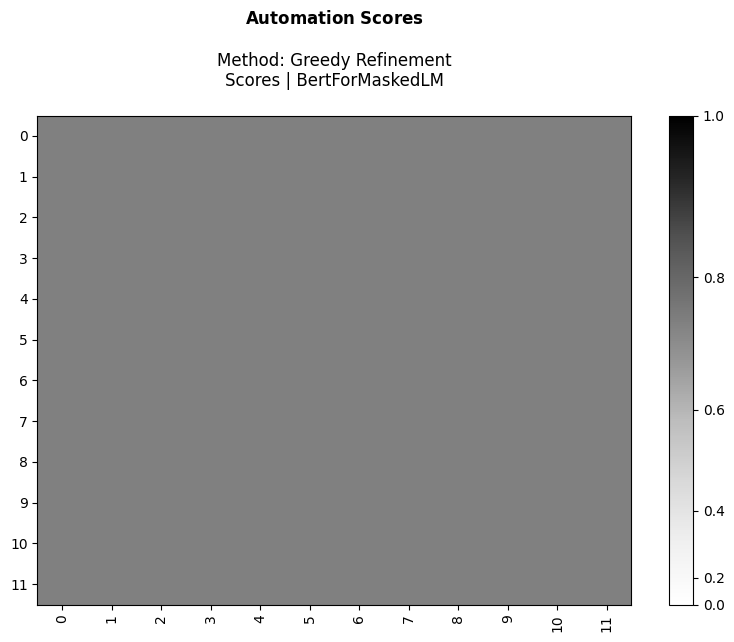

<Figure size 640x480 with 0 Axes>

In [105]:
sq_score = np.reshape(scores, (12, 12))

colors = "Grays"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
masked_sq = np.ma.masked_where(sq_score == -1, sq_score)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(masked_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# put a space element in between automation and scores in text
title = (
    r'$\mathbf{Automation \ Scores}$'  # \mathbf makes the text bold
    '\n\nMethod: Greedy Refinement'
    f'\nScores | {model.config.architectures[0]}'  # Example: replaced model.config...
)
plt.title(f"{title}\n")
plt.show()
plt.savefig('automation_scores_greedy_refinement_k1.png', dpi=300)

In [82]:
# get the (layer, head) associated with the 10 highest scores from automation_results_bert, print the function name from the python file too

import os
folder = "automation_results_bert/scores"
scores = []
for layer in range(12):
    for head in range(12):
        score_path = os.path.join(folder, f"layer{layer}_head{head}_score.txt")
        if os.path.exists(score_path):
            with open(score_path, "r") as f:
                score = float(f.read().strip())
                scores.append((layer, head, score))

names = []
for layer, head, _ in scores:
    code_path = os.path.join("automation_results_bert", "llm_code", f"layer{layer}_head{head}_code.py")
    if os.path.exists(code_path):
        with open(code_path, "r") as f:
            for line in f:
                if line.strip().startswith("def "):
                    func_name = line.strip().split()[1].split('(')[0]
                    names.append(func_name)
                    break
    else:
        names.append("N/A")


highest_scores = sorted(scores, key=lambda x: x[2])[:10]
print("Top 10 highest scores (layer, head, score):")
for (layer, head, score), func_name in zip(highest_scores, names):
    print(f"Layer {layer}, Head {head}: {score} | Function: {func_name}")

Top 10 highest scores (layer, head, score):
Layer 0, Head 0: 0.1561410217310248 | Function: coreference_resolution
Layer 4, Head 3: 0.26261357231480836 | Function: coordination_and_dependency
Layer 5, Head 1: 0.28877842970087697 | Function: coreference_resolution
Layer 6, Head 3: 0.31851691163256496 | Function: auxiliary_main_verb_pattern
Layer 5, Head 6: 0.3205080980885021 | Function: subject_object_focus
Layer 8, Head 5: 0.3303129927925849 | Function: shared_actions_and_physical_isomorphism
Layer 7, Head 11: 0.3413213723599155 | Function: pronominal_reference_and_repetition
Layer 9, Head 9: 0.36677837622280046 | Function: pronoun_reflexive_reference
Layer 9, Head 7: 0.3706347985985409 | Function: relative_position_object_relationship_detection
Layer 6, Head 10: 0.3828267515318551 | Function: coreference_resolution


In [85]:
scores

[(0, 0, 0.1561410217310248),
 (0, 1, 0.7733325301099341),
 (0, 2, 0.7799173514410168),
 (0, 3, 0.811702632629083),
 (0, 4, 0.7178186020652726),
 (0, 5, 0.7527780593049346),
 (0, 6, 0.745477969086829),
 (0, 7, 0.6999382594576555),
 (0, 8, 0.7376186712703945),
 (0, 9, 0.7504497036859923),
 (0, 10, 0.7056853116801501),
 (0, 11, 0.7475800144792139),
 (1, 0, 0.7107957662416117),
 (1, 1, 0.7489446014071989),
 (1, 2, 0.6835955949259095),
 (1, 3, 0.7468822943060587),
 (1, 4, 0.8096895852033202),
 (1, 5, 0.6415397967470383),
 (1, 6, 0.8027039847041375),
 (1, 7, 0.7126689080551405),
 (1, 8, 0.7094478539666469),
 (1, 9, 0.682908654554629),
 (1, 10, 0.7861694867789473),
 (1, 11, 0.6993052251978773),
 (2, 0, 0.7580122185440504),
 (2, 1, 0.7609443839483394),
 (2, 2, 0.7281091503630104),
 (2, 3, 0.49379646359414037),
 (2, 4, 0.6945140578532488),
 (2, 5, 0.6966035141648242),
 (2, 6, 0.69133719024696),
 (2, 7, 0.688583392268501),
 (2, 8, 0.685181887567463),
 (2, 9, 0.7386541101835438),
 (2, 10, 0.73385

In [83]:
# find "coreferent_entity_focus" function which (layer, head) is it

for layer in range(12):
    for head in range(12):
        code_path = os.path.join("automation_results_bert", "llm_code", f"layer{layer}_head{head}_code.py")
        if os.path.exists(code_path):
            with open(code_path, "r") as f:
                for line in f:
                    if line.strip().startswith("def coreferent_entity_focus"):
                        print(f"'coreferent_entity_focus' found in Layer {layer}, Head {head}")
                        break

'coreferent_entity_focus' found in Layer 3, Head 8


In [10]:
# get the (layer, head) associated with the following python functions: ['punctuation_conjunction_attention', 'punctuation_conjunction_dependency', 'conjunction_coherence', 'coordination_alignment'], also print score

import os
folder = "automation_results_bert/scores"
functions = ['punctuation_conjunction_attention', 'punctuation_conjunction_dependency', 'conjunction_coherence', 'coordination_alignment']
folders = []

for layer in range(12):
    for head in range(12):
        code_path = os.path.join("automation_results_bert", "llm_code", f"layer{layer}_head{head}_code.py")
        if os.path.exists(code_path):
            with open(code_path, "r") as f:
                code = f.read()
                for func in functions:
                    if f"def {func}(" in code:
                        folders.append((layer, head, func)) 

print("Functions found in (layer, head, function):")
for layer, head, func in folders:
    print(f"Layer {layer}, Head {head}: {func}")

print("Scores found in (layer, head, function):\n")
for layer, head, func in folders:
    score_path = os.path.join(folder, f"layer{layer}_head{head}_score.txt")
    if os.path.exists(score_path):
        with open(score_path, "r") as f:
            score = f.read().strip()
            print(f"Layer {layer}, Head {head}: {func} - Score: {float(score):.2f}")

Functions found in (layer, head, function):
Layer 1, Head 5: punctuation_conjunction_attention
Layer 2, Head 4: punctuation_conjunction_dependency
Layer 2, Head 7: conjunction_coherence
Layer 4, Head 1: coordination_alignment
Scores found in (layer, head, function):

Layer 1, Head 5: punctuation_conjunction_attention - Score: 0.64
Layer 2, Head 4: punctuation_conjunction_dependency - Score: 0.69
Layer 2, Head 7: conjunction_coherence - Score: 0.69
Layer 4, Head 1: coordination_alignment - Score: 0.64


In [50]:
# !pip uninstall matplotlib
# !pip install matplotlib
import matplotlib.pyplot as plt

name_to_idx = {fn.__name__: i for i, fn in enumerate(programs)}
new_order = [name_to_idx[name] for group in groups for name in group]
S_grouped = S[np.ix_(new_order, new_order)]
colors = "Purples_r"
fig, ax = plt.subplots(1, 1, figsize=(8,8))
im2 = ax.imshow(S_grouped, cmap=colors, aspect='auto')
# ax.set_axis_off()
ax.set_xticks(range(len(programs)))
ax.set_yticks(range(len(programs)))
ax.set_xticklabels([p.__name__ for p in programs], rotation=90)
ax.set_yticklabels([p.__name__ for p in programs])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Similarity Matrix\n", weight='bold')
plt.show()

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

In [6]:
# sum scores in roberta/scores txt

import os
folder = "automation_results_roberta/scores"
scores = []
for filename in os.listdir(folder):
    if filename.endswith(".txt"):
        with open(os.path.join(folder, filename), 'r') as f:
            content = f.read().strip()
            try:
                content = float(content)
                if content != content:  # Check for NaN
                    content = 1.0
            except ValueError:
                content = 1.0
            scores.append(content)

scores

[0.4937223824701005,
 0.7027379858172118,
 0.6152407728591935,
 1.0,
 0.6496044635658186,
 0.8104614780065198,
 0.7070634877899534,
 0.7426189029242453,
 0.4844657315325892,
 1.0,
 0.80964632273633,
 0.7302948734079142,
 0.8030382673744894,
 0.8215691110869259,
 0.5558846376702122,
 0.7440174897534921,
 0.7959446729481947,
 0.7388417255099533,
 0.7477251748191319,
 0.8211317563322759,
 0.7921454277289668,
 0.7795969063410324,
 0.8031091695741677,
 0.7806976181241654,
 0.7994145709327791,
 0.5104023830497546,
 0.7909409907666631,
 0.5299333632778336,
 0.5582278686340649,
 0.7549976115634724,
 0.8053002919941274,
 0.4907640678626391,
 0.7919973411229121,
 0.5702707125103388,
 0.5180585329241036,
 0.7876419629595162,
 0.5280294531098547,
 0.7469301784238402,
 0.7481638117627568,
 0.41249297457599965,
 0.7070154858410311,
 0.7580183079877547,
 0.2977470899629216,
 0.27946054048065494,
 0.5147114851494471,
 0.3962264492520716,
 0.7232286039386582,
 0.47730896827638425,
 0.3629445982920525,


In [1]:
import matplotlib.pyplot as plt

In [9]:
!pip install regex
import regex

In [106]:
# get all programs from automation_refinement/master_list and load these python functions as patterns = [executable functions]

import os
import importlib.util
import types
import numpy as np
from transformers import AutoTokenizer, AutoModel
import regex as re
import pandas as pd
import spacy
from transformers import PreTrainedTokenizerBase, PreTrainedModel
from typing import Optional, Tuple, Callable
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

folder = "automation_refinement_gpt2/master_list"
patterns = []

for filename in os.listdir(folder):
    if filename.endswith(".py"):
        code_path = os.path.join(folder, filename)
        spec = importlib.util.spec_from_file_location(f"module_{filename[:-3]}", code_path)
        module = importlib.util.module_from_spec(spec)
        module.__dict__['np'] = np
        # get pretrainedtokenizerbase, from typing import Optional, Tuple, Callable
        module.__dict__['PreTrainedTokenizerBase'] = PreTrainedTokenizerBase
        module.__dict__['Optional'] = Optional
        module.__dict__['Tuple'] = Tuple
        module.__dict__['Callable'] = Callable
        module.__dict__['spacy'] = spacy
        

        try:
            spec.loader.exec_module(module)
            for attr_name in dir(module):
                attr = getattr(module, attr_name)
                if isinstance(attr, types.FunctionType):
                    patterns.append(attr)
                    break
        except Exception as e:
            print(f"Error loading program from {filename}: {e}")
            continue

print(f"Loaded {len(patterns)} patterns.")
for i, prog in enumerate(patterns):
    print(f"{i}: {prog.__name__}")

Loaded 35 patterns.
0: cls_attention
1: dependencies
2: dominant_subject_attention
3: eos_attention
4: event_sequence_emphasis
5: first_entity_emphasis
6: first_token_dominance
7: first_token_emphasis
8: head_initial_token_emphasis
9: initial_element_subsequent_reference_attention
10: initial_phrase_emphasis
11: initial_reference_attention
12: initial_token_attachment
13: initial_token_attention
14: initial_token_dominance
15: initial_token_emphasis
16: initial_token_emphasis_subsequent_dominance
17: last_token_attention
18: leading_contextual_emphasis
19: lexical_contextual_linking
20: next_attention
21: pos_alignment
22: previous_attention
23: punctuation_attention
24: relative_position_attention
25: repeated_attention
26: same_attention
27: sentence_beginning_emphasis
28: sentence_initial_dominance
29: sentence_initiation_emphasis
30: sentence_level_initial_token_repetition
31: sentence_start_dominance
32: sentence_start_emphasis
33: special_token_attention
34: uniform_attention


In [34]:
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------ --------------------------------- 2.1/12.8 MB 11.2 MB/s eta 0:00:01
     ------------- -------------------------- 4.5/12.8 MB 11.8 MB/s eta 0:00:01
     --------------------- ------------------ 6.8/12.8 MB 11.8 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 11.8 MB/s eta 0:00:01
     ----------------------------------- --- 11.8/12.8 MB 11.8 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 11.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [50]:
# make patterns_strong excluding ["adverbial_modulation", "conjunction_based_grouping", "dependencies", "pos_alignment", "semantics_comma_separation"]:
patterns_strong = [p for p in patterns if p.__name__ not in ["adverbial_modulation", "conjunction_based_grouping", "dependencies", "pos_alignment", "semantics_comma_separation"]]
len(patterns_strong)

20

In [ ]:
test_sentences = sentences[135:137]
scores = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))
top_k = 1

for layer in range(num_layers):
    for head in range(num_heads):
        print(f"Analyzing Layer {layer}, Head {head}...")
        sentence_scores = []
        for sentence in test_sentences:
            inputs = tokenizer(sentence, return_tensors="pt")
            outputs = model(**inputs, output_attentions=True)
            attention = outputs.attentions[layer][0, head].detach().numpy()
            y = attention.flatten()

            X = []
            for pattern in patterns_strong:
                X.append(pattern(sentence, torch_tokenizer)[1].flatten())
            X_n = np.array(X).T
            y = y.flatten()

            # avoid ValueError: Input X contains NaN.
            X_n = np.nan_to_num(X_n)
            y = np.nan_to_num(y)

            reg = LinearRegression().fit(X_n, y)
            side_length = int(np.sqrt(len(y)))
            y = y.reshape((side_length, side_length))

            # pred_att = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
            # pred att should be the intercept + sum of top_k patterns based on magnitude of coef
            top_indices = np.argsort(np.abs(reg.coef_))[-top_k:]
            pred_att = reg.intercept_ + sum(reg.coef_[i] * X[i] for i in top_indices)
            pred_att = pred_att.reshape((side_length, side_length))

            if top_k == 1:
                #pred_att is just the single pattern with highest coef, it isn't equal to a sum at all
                fn_highest_coeff = patterns_strong[np.argmax(np.abs(reg.coef_))]
                pred_att = fn_highest_coeff(sentence, torch_tokenizer)[1]
                print(f"Using pattern: {fn_highest_coeff.__name__}")

            jensonshannon_distances = []
            for row_att, row_out in zip(y, pred_att):
                jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
            score = np.mean(jensonshannon_distances)
            sentence_scores.append(score)
        
        scores[layer, head] = np.mean(sentence_scores)
        # print(f"Score for Layer {layer}, Head {head}: {scores[layer, head]}")

# for each head: do linear interpolation on patterns, set pred_att to sum with top_k hypotheses based on parameter magnitude

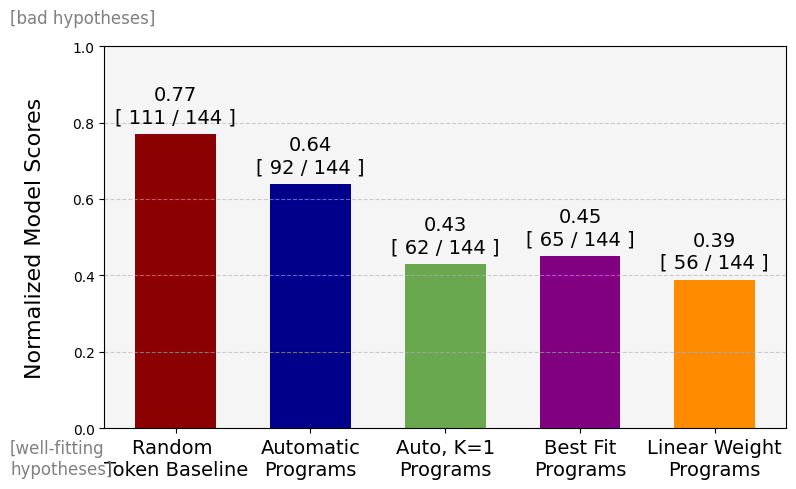

In [88]:
# PLOT DIFFERENT SUMMARY SCORES FOR THE MODEL

max_score = model.config.num_hidden_layers * model.config.num_attention_heads
raw_scores = [111, 92, 62, 65, 56]
labels = ['Random \nToken Baseline', 'Automatic\nPrograms', 'Auto, K=1\nPrograms', 'Best Fit\nPrograms', 'Linear Weight\nPrograms']
colors = ['darkred', 'darkblue', '#6aa84f', '#800080', "darkorange"]

# Normalize scores: lower scores become higher bars
scores = [(score / max_score) for score in raw_scores]
fig, ax = plt.subplots(figsize=(8, 5))
bars = plt.bar(labels, scores, color=colors, width=0.6)

# Add text labels on top of bars
for bar, raw, norm in zip(bars, raw_scores, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f'{norm:.2f}\n[ {int(raw)} / {max_score} ]', ha='center', va='bottom', fontsize=14)
ax.set_facecolor('#F5F5F5')

plt.ylim(0, 1.0)
# plt.title('Normalized Error (1 - Score / Max Score)')
plt.xticks(fontsize=14)
plt.text(plt.xlim()[0]-0.7, plt.ylim()[1]+0.05, '[bad hypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.text(plt.xlim()[0]-0.7, plt.ylim()[0]-0.13, '[well-fitting\nhypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.ylabel('Normalized Model Scores', fontsize=16, labelpad=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [99]:
np.save("bert_head_greedy_scores_2.npy", scores)

In [64]:
np.nanmean(scores)

np.float64(0.34298533844313867)

In [65]:
# convert all nan values to mean in scores

mean_score = np.nanmean(scores)
scores = np.where(np.isnan(scores), mean_score, scores)

C:\Users\amkah\AppData\Local\Temp\ipykernel_21756\653035461.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


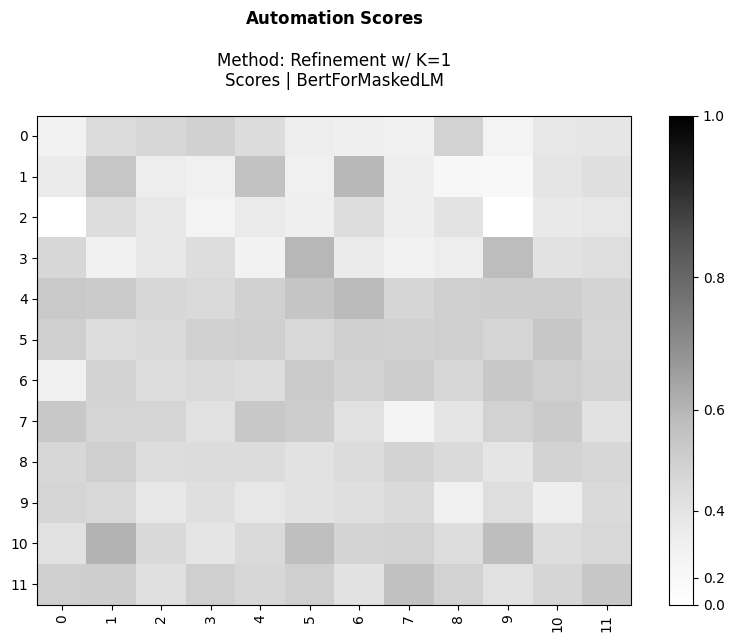

In [76]:
from matplotlib.colors import PowerNorm
sq_score = scores

colors = "Grays"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# masked_sq = np.ma.masked_where(sq_score == -1, sq_score)
# masked_sq converts na to mean
masked_sq = np.ma.masked_invalid(sq_score)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(masked_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# put a space element in between automation and scores in text
title = (
    r'$\mathbf{Automation \ Scores}$'  # \mathbf makes the text bold
    '\n\nMethod: Refinement w/ K=1'
    f'\nScores | {model.config.architectures[0]}'  # Example: replaced model.config...
)
plt.title(f"{title}\n")
plt.show()

In [95]:
print(scores)

[[0.15614102 0.77333253 0.77991735 0.81170263 0.7178186  0.75546454
  0.77434856 0.71341011 0.73761867 0.76518758 0.70568531 0.74758001]
 [0.71079577 0.7489446  0.68996212 0.74688229 0.80968959 0.6415398
  0.80270398 0.71266891 0.70944785 0.68290865 0.78616949 0.69930523]
 [0.75801222 0.76094438 0.72810915 0.49379646 0.69451406 0.69660351
  0.69133719 0.68858339 0.68518189 0.73865411 0.75272346 0.76541526]
 [0.51632687 0.6340777  0.58876915 0.74037    0.56905638 0.62845019
  0.6161181  0.69862948 0.43156646 0.72505321 0.69403841 0.69410723]
 [0.46149754 0.67259875 0.42671076 0.3180412  0.51379185 0.49920757
  0.74318169 0.75284692 0.54778621 0.58433963 0.51910424 0.45503824]
 [0.42925105 0.28877843 0.4931031  0.54513019 0.49332205 0.6850833
  0.3205081  0.79076045 0.45128451 0.56567916 0.5175727  0.58759792]
 [0.66527822 0.44795136 0.47073292 0.31851691 0.39476439 0.49732543
  0.61061636 0.66757436 0.44941968 0.54281576 0.38282675 0.58618881]
 [0.64177883 0.5141284  0.45435256 0.625263

In [96]:
np.save("data/bert_head_greedy_scores.npy", scores)

C:\Users\amkah\AppData\Local\Temp\ipykernel_21756\4222344843.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


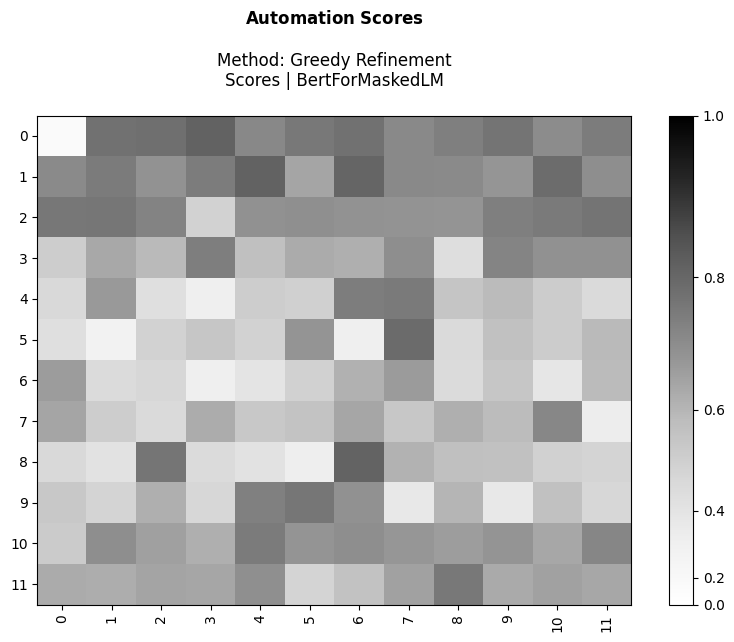

<Figure size 640x480 with 0 Axes>

In [92]:
sq_score = np.reshape(scores, (12, 12))

colors = "Grays"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
masked_sq = np.ma.masked_where(sq_score == -1, sq_score)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(masked_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# put a space element in between automation and scores in text
title = (
    r'$\mathbf{Automation \ Scores}$'  # \mathbf makes the text bold
    '\n\nMethod: Greedy Refinement'
    f'\nScores | {model.config.architectures[0]}'  # Example: replaced model.config...
)
plt.title(f"{title}\n")
plt.show()
plt.savefig('automation_scores_refinement_k1.png', dpi=300)

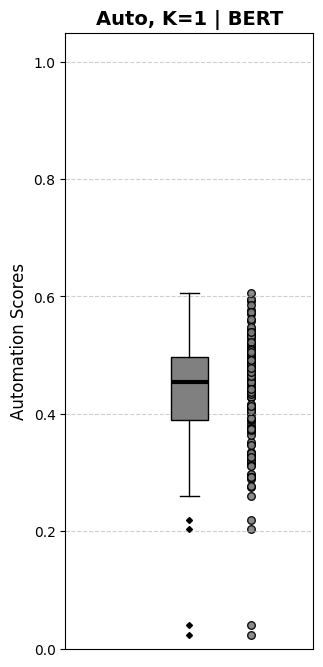

In [80]:
def find_outliers(data):
    data = np.array(data)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound, Q1, Q3, IQR

outliers, lower_bound, upper_bound, Q1, Q3, IQR = find_outliers(scores)

def plot_scores_boxplot(scores):
    plt.figure(figsize=(3.2,8))
    plt.boxplot(
        scores,
        positions=[0.75], 
        vert=True,
        patch_artist=True,
        medianprops={'color': 'black', 'linewidth': 3},
        boxprops={'facecolor': 'gray', 'edgecolor': 'black'},
        flierprops={'marker': 'D', 'markerfacecolor': 'black', 'markersize': 3, 'linestyle': 'none'}
    )

    plt.title('Auto, K=1 | BERT', fontsize=14, weight='bold')
    plt.ylabel('Automation Scores', fontsize=12)
    plt.xticks([])
    plt.ylim(0, 1.05)

    #insert the text 'WIP' in center of plot
    # plt.text(0.75, 0.5, 'WIP', fontsize=12, ha='center', va='center')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    x = np.ones_like(scores)
    plt.scatter(
        x,
        scores,
        color='gray',
        edgecolor='black',
        s=30,
        alpha=0.9,
    )
    plt.show()

flattened_scores = scores.flatten()
plot_scores_boxplot(flattened_scores)

C:\Users\amkah\AppData\Local\Temp\ipykernel_21756\3463883704.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colors).copy()


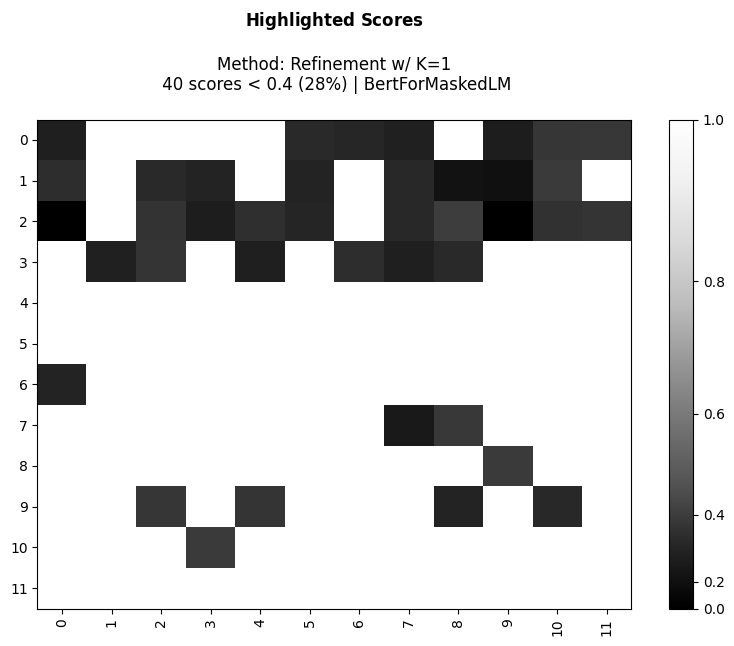

In [78]:
import matplotlib.pyplot as plt
colors = "Grays_r"
plt.rcParams['text.usetex'] = False

score_threshold = 0.4

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
highlighted_sq = np.where(sq_score < score_threshold, sq_score, np.nan)
# make all non-highlighted values white (1.0)
highlighted_sq = np.where(np.isnan(highlighted_sq), 1.0, highlighted_sq)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(highlighted_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
# import matplotlib
# print("usetex:", matplotlib.rcParams['text.usetex'])
# plt.rcParams['text.usetex'] = False

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# make automation bold
# get number of highlighted scores
num_highlighted = np.sum(sq_score < score_threshold)
title = (
    r'$\mathbf{Highlighted\ Scores}$'
    '\n\nMethod: Refinement w/ K=1'
    f'\n {num_highlighted} scores < {score_threshold} ({num_highlighted/(len(sq_score)**2)*100:.0f}%) | {model.config.architectures[0]}\n')
# title = "Automation Scores\n"
plt.title(title)
plt.show()

In [45]:
from nltk import sent_tokenize
import csv

# use bert
torch_model = AutoModel.from_pretrained("bert-base-uncased")
torch_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

num_layers = torch_model.config.num_hidden_layers
num_heads = torch_model.config.num_attention_heads
activations = {} 

file = 'data/small_text.csv'
df = pd.read_csv(file)
sentences = []
for paragraph in df['text']:
    sentences.extend(sent_tokenize(paragraph))
sentences = sentences[:10_000]

short = sentences[:8]
csv_file_name = "data/bert_refinement.csv"
with open(csv_file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    for pattern in patterns:
        if pattern.__name__ in ["adverbial_modulation", "conjunction_based_grouping", "dependencies", "pos_alignment", "semantics_comma_separation"]: continue
        print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
        avg_score = []
        for idx, sentence in enumerate(short):
            print(f"\tProcessing sentence {idx}/{len(short)}")
            for i in range(num_layers):
                for j in range(num_heads):
                    if i != 3 or j != 9: continue
                    nlp = spacy.load("en_core_web_sm")
                    score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                    if score < 0.55:
                        avg_score.append((idx, pattern.__name__, i, j, score))
        
        score_dict = {}
        for idx, pattern_name, i, j, score in avg_score:
            score_dict.setdefault((i, j), []).append((pattern_name, score))
        for (i, j), values in score_dict.items():
            scores = [score for _, score in values]
            avg_score_val = sum(scores) / len(scores)
            pattern_name = values[0][0]
            activations[(i, j)] = (pattern_name, avg_score_val)
            print(f"Layer {i}, Head {j} - Score: {avg_score_val:.2f}")
            writer.writerow([i, j, pattern.__name__, avg_score_val])


Currently Analyzing pattern: appositive_phrase_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: compound_element_association
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: compound_modifier_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: lexical_association
	Processing sentence 0/8


c:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_refinement/master_list\compound_word_attention.py:24: RuntimeWarning: invalid value encountered in divide
  out = out / out.sum(axis=1, keepdims=True)


	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: compound_word_attention_pattern
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: high_saliency_relationship_detection
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: next_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8
Layer 3, Head 9 - Score: 0.47

Currently Analyzing 

c:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_refinement/master_list\semantic_role_association.py:25: RuntimeWarning: invalid value encountered in divide
  out = out / out.sum(axis=1, keepdims=True)


	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: sentence_boundary_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: sentence_structure_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: semantic_similarity_attention
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8


c:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_refinement/master_list\subordinate_clause_linking.py:25: RuntimeWarning: invalid value encountered in divide
  out = out / out.sum(axis=1, keepdims=True)


	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8

Currently Analyzing pattern: temporal_sequence_linking
	Processing sentence 0/8
	Processing sentence 1/8
	Processing sentence 2/8
	Processing sentence 3/8
	Processing sentence 4/8
	Processing sentence 5/8
	Processing sentence 6/8
	Processing sentence 7/8


In [ ]:
# get all programs from automation_refinement/master_list and load these python functions as patterns = [executable functions]
# loop over heads and using three sentences get an average score for each head for each pattern, save the name and best score of best fitting pattern
# build a matrix (layers * heads) with the best fitting pattern_name and best_Score

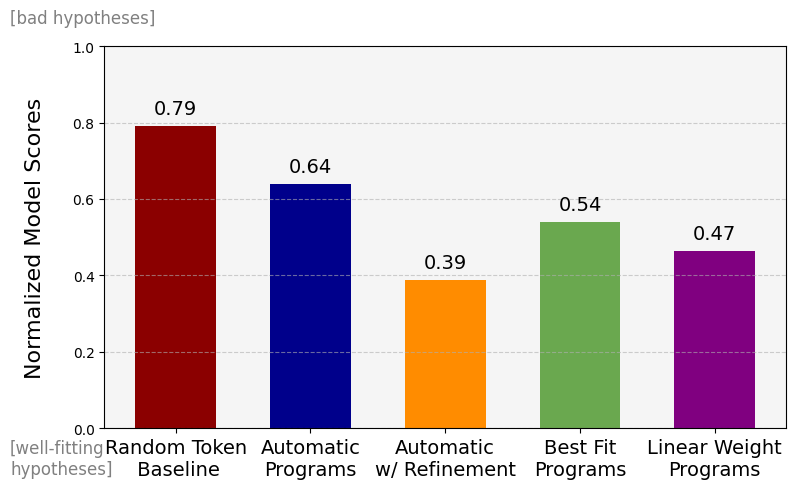

In [18]:
# PLOT DIFFERENT SUMMARY SCORES FOR THE MODEL

import matplotlib.pyplot as plt

max_score = 144
raw_scores = [114, 92.05, 56, 77.9, 67]
labels = ['Random Token\n Baseline', 'Automatic\nPrograms', 'Automatic\nw/ Refinement', 'Best Fit\nPrograms', 'Linear Weight\nPrograms']
colors = ['darkred', 'darkblue', '#FF8C00', '#6aa84f', '#800080']

# Normalize scores: lower scores become higher bars
scores = [(score / max_score) for score in raw_scores]
fig, ax = plt.subplots(figsize=(8, 5))
bars = plt.bar(labels, scores, color=colors, width=0.6)

# Add text labels on top of bars
for bar, raw, norm in zip(bars, raw_scores, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f'{norm:.2f}', ha='center', va='bottom', fontsize=14)
ax.set_facecolor('#F5F5F5')

plt.ylim(0, 1.0)
# plt.title('Normalized Error (1 - Score / Max Score)')
plt.xticks(fontsize=14)
plt.text(plt.xlim()[0]-0.7, plt.ylim()[1]+0.05, '[bad hypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.text(plt.xlim()[0]-0.7, plt.ylim()[0]-0.13, '[well-fitting\nhypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.ylabel('Normalized Model Scores', fontsize=16, labelpad=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
    def forward(self, x, edge_index,n_id, feature_vec):
        transformed_feature = self.feature_transform(feature_vec)

        text = [self.texts[i] for i in n_id.cpu().numpy()]
        tokens = self.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')

        tokens = tokens.to(edge_index.device)
        input_embeddings = self.text_model.get_input_embeddings()(tokens['input_ids'])
        
        if self.soft == False:
            outputs = self.text_model(inputs_embeds=input_embeddings)
            hidden_states = outputs.last_hidden_state
            text_embedding = hidden_states[:, 0, :]

        graph_embedding = transformed_feature
        count = 0
        
        for gcn_layer in self.gcn_layers:
            edge_index = edge_index.long()
            
            if self.soft:
                graph_embedding = graph_embedding.unsqueeze(1)
                modified_embeddings = torch.cat((graph_embedding, input_embeddings), dim=1)
                attention_mask = tokens['attention_mask']
                batch_size = attention_mask.shape[0]
                new_token_mask = torch.ones((batch_size, 1), dtype=attention_mask.dtype, device=attention_mask.device)
                attention_mask = torch.cat([new_token_mask, attention_mask], dim=1)
                outputs = self.text_model(inputs_embeds=modified_embeddings, attention_mask=attention_mask)
                hidden_states = outputs.last_hidden_state
                text_embedding = hidden_states[:, 0, :]

            graph_embedding_for_attention = graph_embedding.squeeze(1).unsqueeze(0)  # [1, batch_size, embedding_dim]
            text_embedding_for_attention = text_embedding.unsqueeze(0)  # [1, batch_size, embedding_dim]
            text_to_graph_attention, _ = self.cross_attention(graph_embedding_for_attention, 
                                                              text_embedding_for_attention,text_embedding_for_attention)
            text_to_graph_attention = text_to_graph_attention.squeeze(0)  # [batch_size, embedding_dim]

            combined_embedding = (text_embedding + text_to_graph_attention) / 2
            graph_embedding = gcn_layer(combined_embedding, edge_index)

        return self.classifier(graph_embedding),graph_embedding